In [21]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Preprocess LHS simulation results

In [116]:
path0='C:/Users/jisma/altamira/kawesqar24'

In [120]:
result_files = [file for file in os.listdir(path0+'/results') if 'stats' in file]
Nexp = len(result_files)
print('Number of experiments:', Nexp)

Number of experiments: 1000


In [121]:
df0=pd.read_csv(path0+'/results/'+result_files[0], sep=',', skiprows=range(6)).head(1)
model_parameters=df0.columns[:5].to_list()
print('Model parameters:')
for p in model_parameters: print(p) 
model_varables=df0.columns[5:].to_list()
print('\nModel variables:')
for v in model_varables: print(v)

Model parameters:
mu-logistic-whaling-success
whaling-harm-prob
theta
mutation-prob
n-people

Model variables:
[step]
(mean) average-whale-hunt
(std) average-whale-hunt
(mean) average-help-others
(std) average-help-others
(mean) average-fitness
(std) average-fitness
(mean) average-resources
(std) average-resources
(mean) average-social-capital
(std) average-social-capital
(mean) average-disabled
(std) average-disabled


In [122]:
Nsteps = 1000 # Number of the last steps to be considered in the analysis

In [ ]:
# stationary state results
dfr=df0.iloc[:1,:].copy() # pd.DataFrame(columns=df0.columns) # concatenation with empty is deprecated in Pandas
dfr['experiment']=None
for file in result_files:
    df=pd.read_csv(path0+'/results/'+file, sep=',', skiprows=range(6)).tail(Nsteps)
    df['experiment']=int(re.findall(r'\d+', file)[0])
    dfr=pd.concat([dfr,df],axis=0,ignore_index=True)
dfr=dfr.iloc[1:].reset_index(drop=True) # remove the first row
#dfr.to_csv('../results/stationary_state.csv',index=False)

# Checking stationarity
Check if simulations have reached a stationary state in the last 1000 tick

In [2]:
from statsmodels.tsa.stattools import adfuller, kpss
import warnings

In [146]:
dfr=pd.read_csv('../results/stationary_state.csv')

**Stationarity tests**: https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html
- The Augmented Dickey-Fuller (ADF) test checks if the series has a trend or more generally if it is time-dependent (its mean, variance, and autocorrelation structure do not change over time)
- The Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test checks for the presence of stationarity around a deterministic trend (there is no deterministic trend or structural breaks causing non-stationarity)

Beacause the state variables represent mean probabilities and values are always between (0,1), we use the logistic transformation after checking the stationarity of the time series

## Stationarity (1) Average whale hunt

In [147]:
# Stationary test for '(mean) average-whale-hunt'
stationary_test = pd.DataFrame(columns=['experiment', 'ADF Statistic', 'ADF p-value', 
                                        'KPSS Statistic', 'KPSS p-value'])
stationary_test['experiment'] = dfr['experiment'].unique()
for exp in stationary_test['experiment']:
    # logistic trasnformation of the time series
    time_series = dfr[dfr['experiment'] == exp]['(mean) average-whale-hunt'].tail(1000).apply(lambda x: 1 / (1 + np.exp(-x)))
    with warnings.catch_warnings(record=True) as w:
        adf_result = adfuller(time_series)
        kpss_result = kpss(time_series, regression='c')
        stationary_test.loc[exp, 'ADF Statistic'] = adf_result[0]
        stationary_test.loc[exp, 'ADF p-value'] = adf_result[1]
        stationary_test.loc[exp, 'KPSS Statistic'] = kpss_result[0]
        stationary_test.loc[exp, 'KPSS p-value'] = kpss_result[1]

In [148]:
# Number of experiments with positive non-stationary test
pdtest=pd.DataFrame([[len(stationary_test[stationary_test['ADF p-value'] > p]) for p in np.arange(0.01,0.051,0.01)],
              [len(stationary_test[stationary_test['KPSS p-value'] < p]) for p in np.arange(0.01,0.051,0.01)]],
              columns=np.arange(0.01,0.051,0.01), index=['ADF', 'KPSS'])
pdtest.loc['%exp']=pdtest.sum(axis=0).values/len(stationary_test)
pdtest

,0.01,0.02,0.03,0.04,0.05
ADF,13.000,10.000,10.000,9.000,8.000
KPSS,0.000,86.000,114.000,130.000,147.000
%exp,0.013,0.096,0.124,0.139,0.155


In [149]:
p_threshold = 0.05
stationary_test['ADF']=stationary_test['ADF p-value']>p_threshold
stationary_test['KPSS']=stationary_test['KPSS p-value']<p_threshold
stationary_test['stat']=1
stationary_test.loc[stationary_test['ADF'] & stationary_test['KPSS'],'stat']=0 # both positive tests
stationary_test.to_csv('../results/stationary_test1.csv',index=False)
pd.crosstab(stationary_test['ADF'], stationary_test['KPSS'])

KPSS,False,True
ADF,,
False,853,139
True,0,8


In [137]:
# Function to plot the time series of the experiments
def plot_time_series(exps, dfr, var,C=10, Nsteps=1000):
    R=np.ceil(exps.shape[0]/C)
    for i in range(int(R)):
        fig, ax = plt.subplots(figsize=(15, 1.5))
        for j in range(C):
            if i*C+j < exps.shape[0]:
                exp=exps.iloc[i*C+j]
                time_series = dfr.loc[dfr['experiment'] == exp,var].values
                ax.plot(range(j*Nsteps,(j+1)*Nsteps),time_series)
                ax.set_ylim([0,1])
                ax.text(j*Nsteps+300, 1.02, str(exp))
                ax.set_xticks([])
        plt.show()

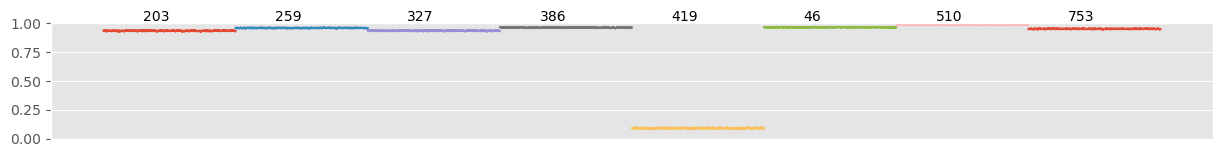

In [150]:
# Plot of the time series of the experiments with ADF test failed
plot_time_series(stationary_test[stationary_test['ADF']]['experiment'], dfr,'(mean) average-whale-hunt')

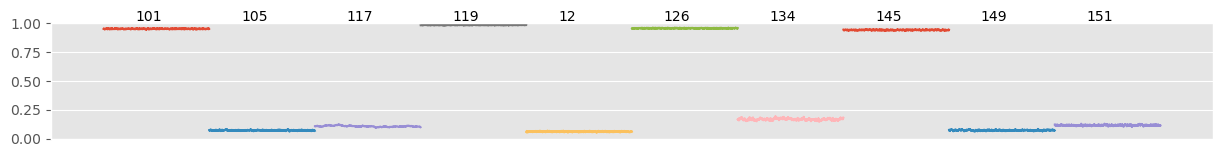

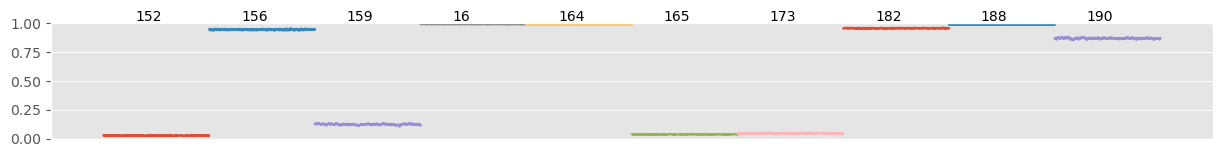

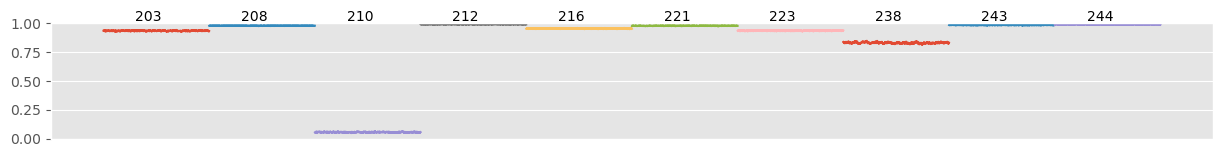

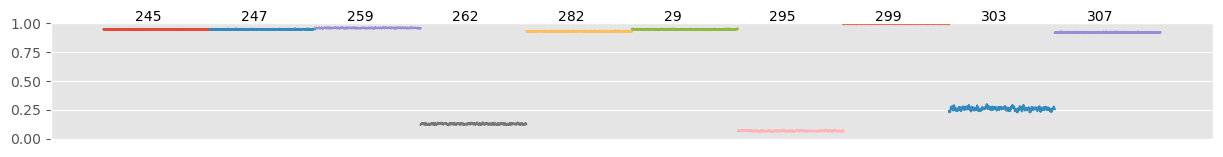

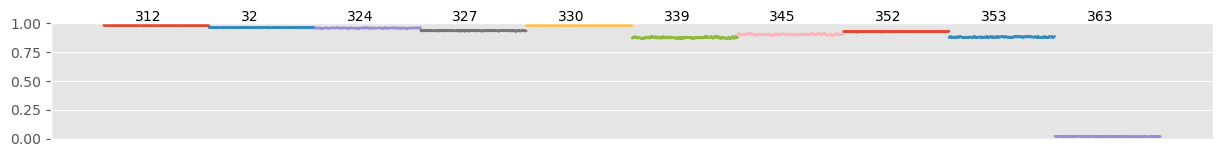

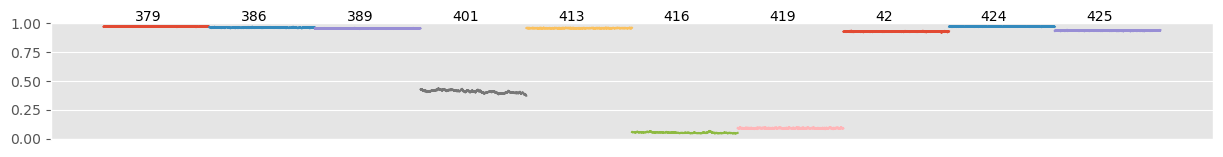

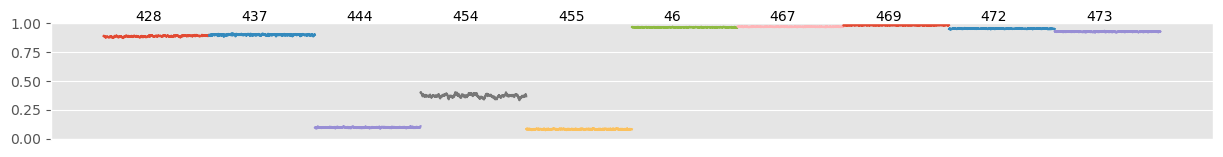

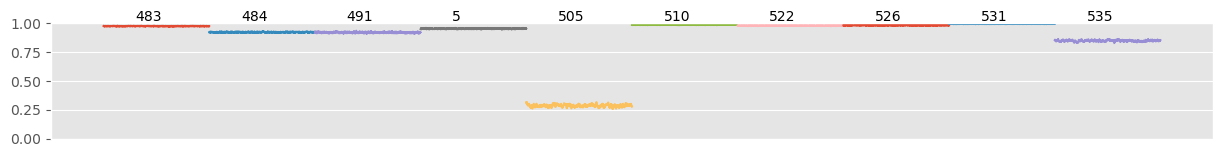

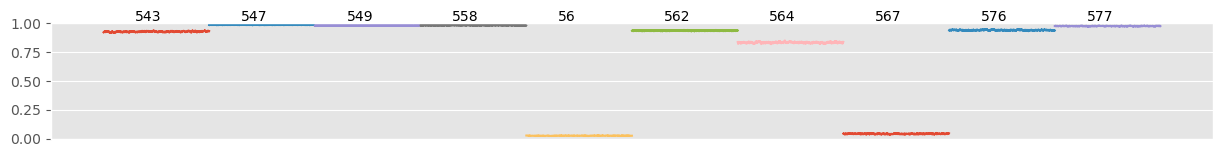

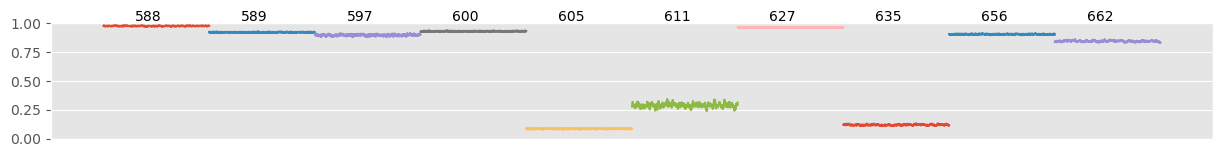

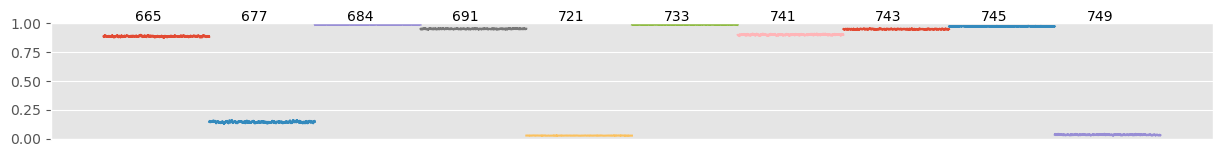

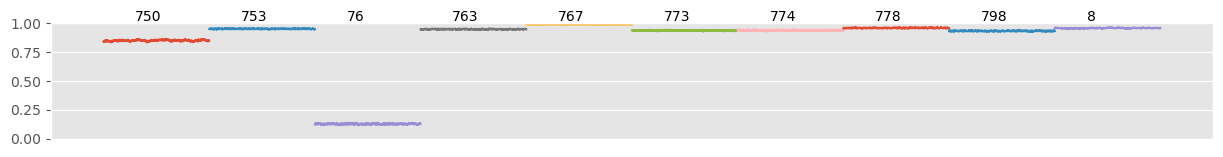

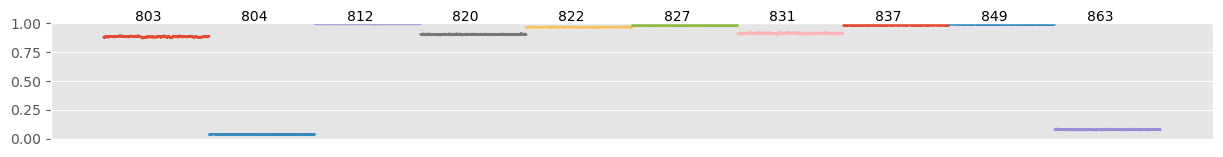

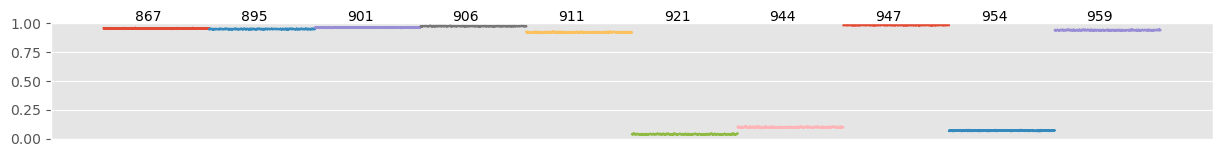

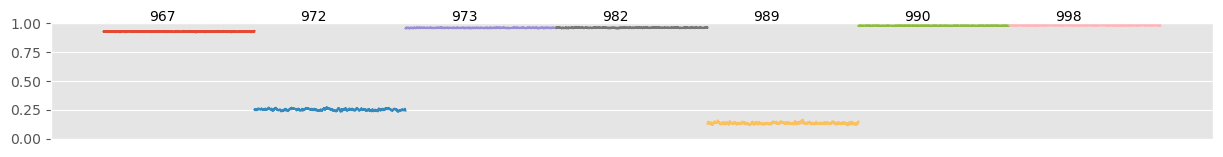

In [151]:
# Plot of the time series of the experiments with KPSS test failed
plot_time_series(stationary_test[stationary_test['KPSS']]['experiment'], dfr,'(mean) average-whale-hunt')

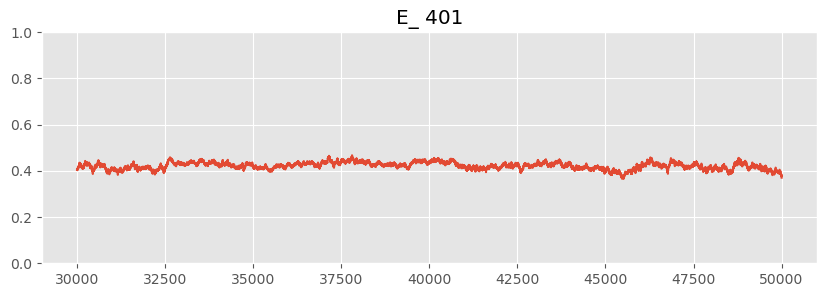

In [152]:
# Plot of the time series of one experiment (last 10000 steps)
exp=401 #454 611
df=pd.read_csv(path0+'/results/result_stats_exp_'+str(exp)+'.csv', sep=',', skiprows=range(6))
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(df['[step]'],df['(mean) average-whale-hunt'])
ax.set_title('E_ '+str(exp))
ax.set_ylim(0, 1)
plt.show()

## Stationarity (2) Averahe help others

In [155]:
# Stationary test for '(mean) average-help-others'
stationary_test = pd.DataFrame(columns=['experiment', 'ADF Statistic', 'ADF p-value', 
                                        'KPSS Statistic', 'KPSS p-value'])
stationary_test['experiment'] = dfr['experiment'].unique()
for exp in stationary_test['experiment']:
    # logistic trasnformation of the time series
    time_series = dfr[dfr['experiment'] == exp]['(mean) average-help-others'].apply(lambda x: 1 / (1 + np.exp(-x)))
    with warnings.catch_warnings(record=True) as w:
        adf_result = adfuller(time_series)
        kpss_result = kpss(time_series, regression='c')
        stationary_test.loc[exp, 'ADF Statistic'] = adf_result[0]
        stationary_test.loc[exp, 'ADF p-value'] = adf_result[1]
        stationary_test.loc[exp, 'KPSS Statistic'] = kpss_result[0]
        stationary_test.loc[exp, 'KPSS p-value'] = kpss_result[1]

In [156]:
# Number of experiments with positive non-stationary test
pdtest=pd.DataFrame([[len(stationary_test[stationary_test['ADF p-value'] > p]) for p in np.arange(0.01,0.051,0.01)],
              [len(stationary_test[stationary_test['KPSS p-value'] < p]) for p in np.arange(0.01,0.051,0.01)]],
              columns=np.arange(0.01,0.051,0.01), index=['ADF', 'KPSS'])
pdtest.loc['%exp']=pdtest.sum(axis=0).values/len(stationary_test)
pdtest


,0.01,0.02,0.03,0.04,0.05
ADF,13.000,11.000,11.000,9.000,9.000
KPSS,0.000,86.000,115.000,129.000,148.000
%exp,0.013,0.097,0.126,0.138,0.157


In [157]:
p_threshold = 0.05
stationary_test['ADF']=stationary_test['ADF p-value']>p_threshold
stationary_test['KPSS']=stationary_test['KPSS p-value']<p_threshold
stationary_test['stat']=1
stationary_test.loc[stationary_test['ADF'] & stationary_test['KPSS'],'stat']=0 # both positive tests
stationary_test.to_csv('../results/stationary_test2.csv',index=False)
pd.crosstab(stationary_test['ADF'], stationary_test['KPSS'])

KPSS,False,True
ADF,,
False,851,140
True,1,8


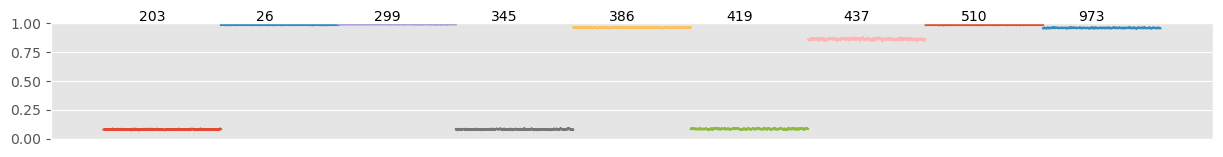

In [158]:
# Plot of the time series of the experiments with ADF test failed
plot_time_series(stationary_test[stationary_test['ADF']]['experiment'], dfr,'(mean) average-help-others')

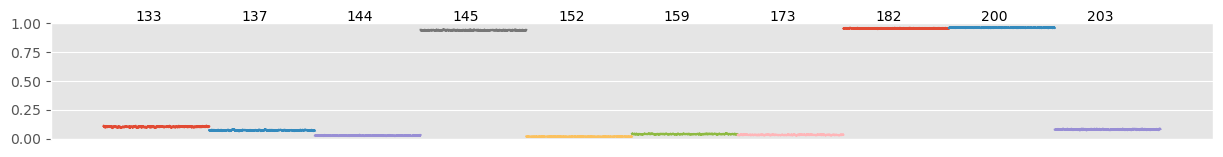

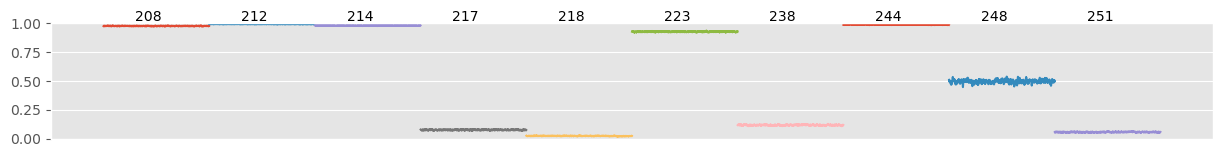

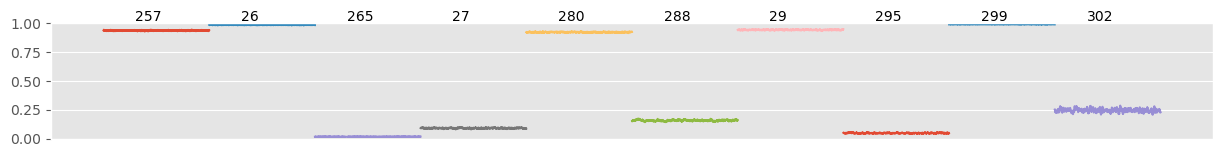

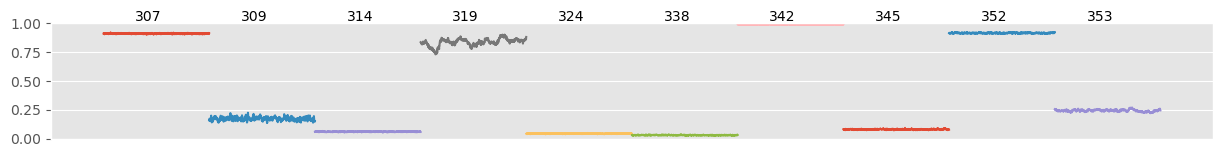

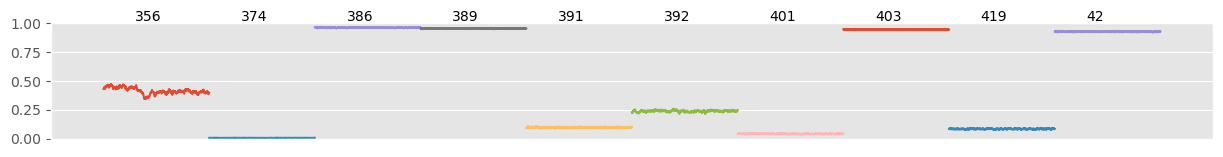

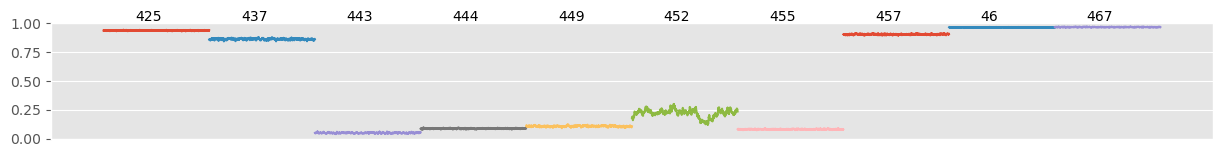

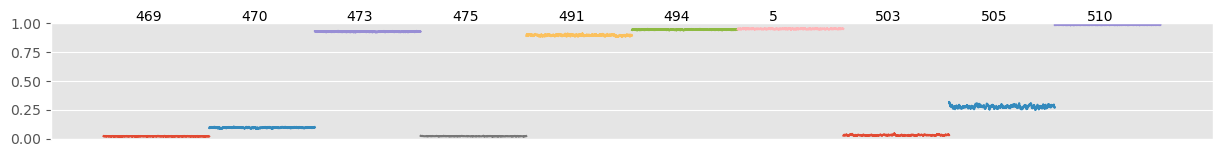

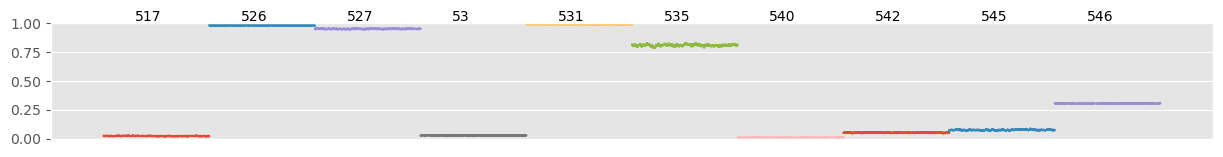

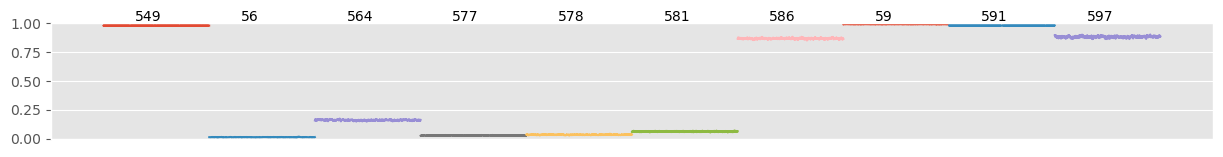

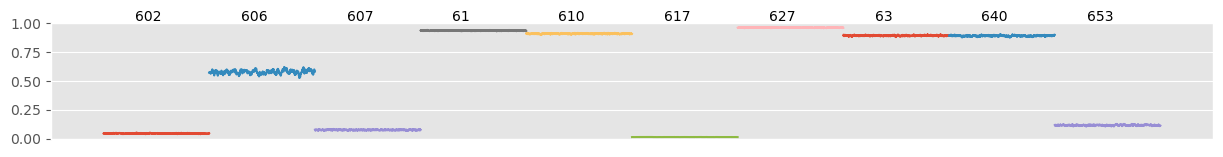

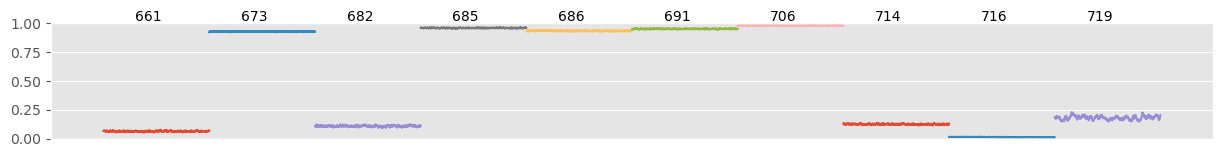

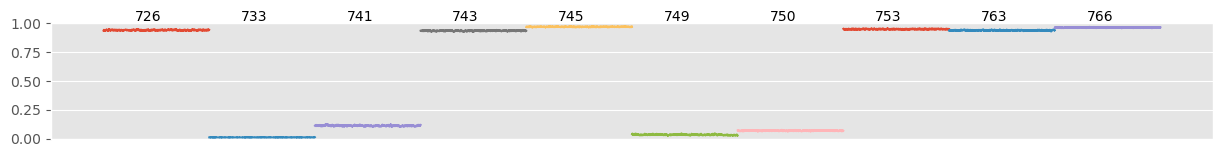

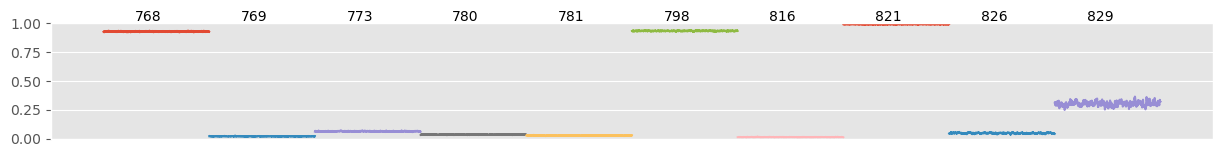

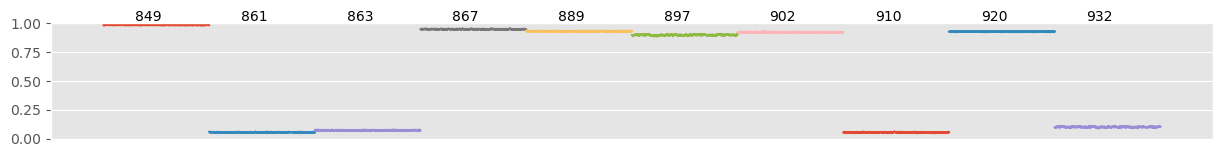

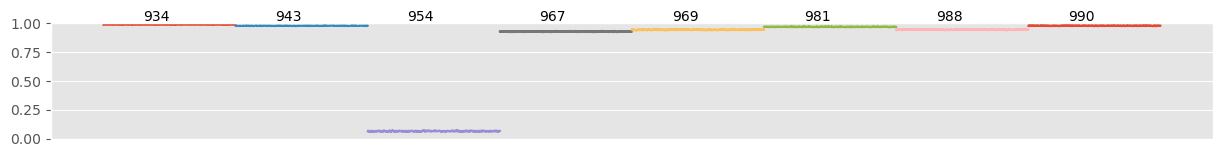

In [159]:
# Plot of the time series of the experiments with KPSS test failed
plot_time_series(stationary_test[stationary_test['KPSS']]['experiment'], dfr,'(mean) average-help-others')

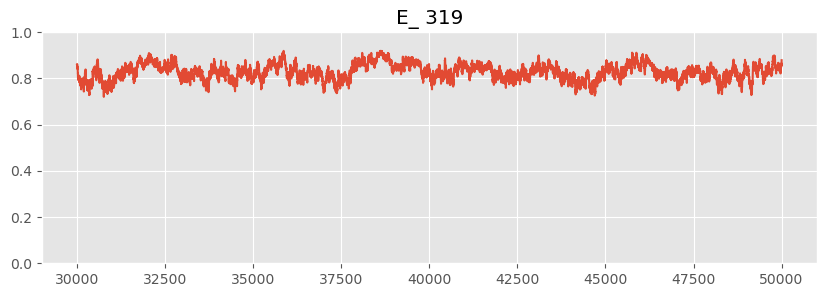

In [160]:
# Plot of the time series of one experiment (last 10000 steps)
exp=319 #452
df=pd.read_csv(path0+'/results/result_stats_exp_'+str(exp)+'.csv', sep=',', skiprows=range(6))
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(df['[step]'],df['(mean) average-help-others'])
ax.set_title('E_ '+str(exp))
ax.set_ylim(0, 1)
plt.show()

# Exploratory analysis

In [162]:
# Average time series of the last ticks by experiment
dfr_sum=dfr.groupby('experiment').mean()

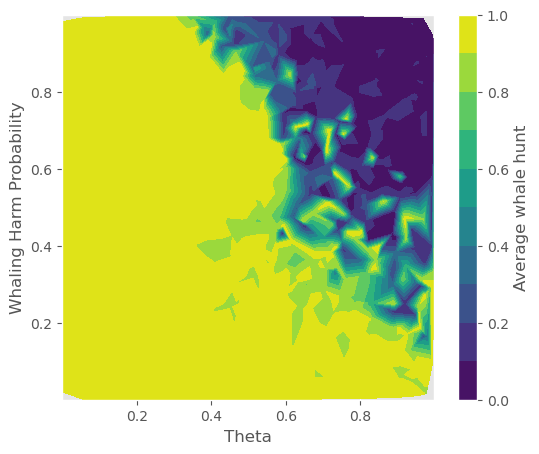

In [163]:
# Average whale hunt by 'theta' and 'whaling-harm-prob'
plt.figure(figsize=(6, 5))
plt.tricontourf(dfr_sum['theta'], dfr_sum['whaling-harm-prob'], dfr_sum['(mean) average-whale-hunt'], 
                levels=10, cmap='viridis',vmin=0, vmax=1)
plt.colorbar(label='Average whale hunt')
plt.xlabel('Theta')
plt.ylabel('Whaling Harm Probability')
#plt.title('Average whale hunt')
plt.savefig('../figures/exploratory_average_whale_hunt_contourplot.svg', format='svg',bbox_inches='tight')
plt.show()

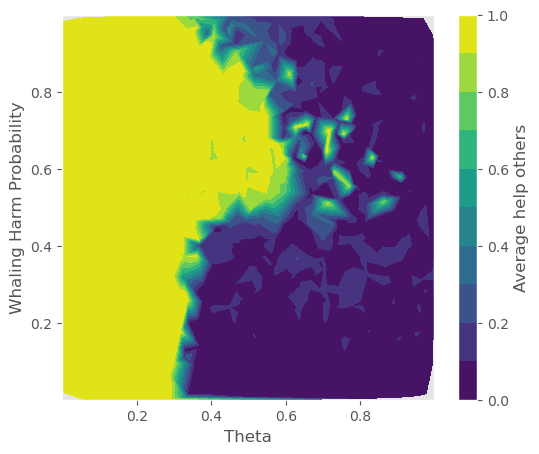

In [164]:
# Average help others by 'theta' and 'whaling-harm-prob'
plt.figure(figsize=(6, 5))
plt.tricontourf(dfr_sum['theta'], dfr_sum['whaling-harm-prob'], dfr_sum['(mean) average-help-others'], 
                levels=10, cmap='viridis',vmin=0, vmax=1)
plt.colorbar(label='Average help others')
plt.xlabel('Theta')
plt.ylabel('Whaling Harm Probability')
#plt.title('Average help others',font)
plt.savefig('../figures/exploratory_average_help_others_contourplot.svg', format='svg',bbox_inches='tight')
plt.show()